In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.init as init

import numpy as np
import matplotlib.pyplot as plt

from utils.prune import apply_mask
from utils.count_improvement import improvements
from utils.active_weights import calculate_active_weights_percentage

In [9]:
# Verificar si la GPU está disponible y establecer el dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 4 * 4, 128)  # Adjusted dimensions here
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 128 * 4 * 4)  # Adjusted dimensions here
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


In [11]:
net = Net().to(device)
varianzas_net = Net().to(device)
individuo = Net().to(device)

Cargamos los datos

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10('./../data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10('./../data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


In [13]:
# Definimos la función de pérdida para calcular el error
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

Realizamos el "entrenamiento"

In [ ]:
# train loop
train_loss = []
train_loss_mean = []
test_accuracies = []
n_individuo = 1
accuracy_threshold = 0.95

# Multiplicamos los pesos de varianzas para que sean numero sgrandes
with torch.no_grad():
    for param in varianzas_net.parameters():
        param *= 10000

#Guardo el mejor individuo y la red original que tendrá que ser reestablecida cad epoca
best_individo_state_dict = individuo.state_dict()
net_state_dict = net.state_dict()

#train loop
while True:
    net.load_state_dict(net_state_dict)
    if n_individuo == 1:
        print(f" --------------------- Individuo {n_individuo} --------------------- ")

        masked_net = apply_mask(net, individuo)
        
        results = calculate_active_weights_percentage(individuo)
        print("Porcentaje de parámetros activos: {:.2f}%".format(results["active_percentage"]))

        masked_net.train()
        running_loss = 0.0
        # Train for 1 epoch
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = masked_net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_loss.append(running_loss / len(train_loader))

        masked_net.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data in test_loader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = masked_net(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = correct / total
        #train_loss_mean.append(np.mean(train_loss))
        test_accuracies.append(accuracy)
        #print(f"Accuracy: {accuracy}, loss mean: {train_loss_mean[-1]}")
        print(f"Accuracy: {accuracy}", f"Loss: {train_loss[-1]}")
        best_loss = train_loss[-1]
        if accuracy > accuracy_threshold:
            break
        n_individuo += 1

        #sumamos varianzas para crear un nuevo individuo desde el anterior
        nuevo_individuo = Net().to(device)
        state_dict_ind = individuo.state_dict()
        state_dict_var = varianzas_net.state_dict()
        state_dict_suma = {}

        for key in state_dict_ind:
            if state_dict_ind[key].size() == state_dict_var[key].size():  
                std_dev = state_dict_var[key]
                noise = torch.normal(0, torch.abs(std_dev))
                state_dict_suma[key] = state_dict_ind[key] + torch.sign(std_dev) * noise
            else:
                state_dict_suma[key] = state_dict_ind[key]

        nuevo_individuo.load_state_dict(state_dict_suma)
        
    else:
        print(f" --------------------- Individuo {n_individuo} --------------------- ")

        masked_net = apply_mask(net, nuevo_individuo)

        results = calculate_active_weights_percentage(individuo)
        print("Porcentaje de parámetros activos: {:.2f}%".format(results["active_percentage"]))
        
        masked_net.train()
        running_loss = 0.0
        # Train for 1 epoch
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = masked_net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_loss.append(running_loss / len(train_loader))

        masked_net.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data in test_loader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = masked_net(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = correct / total
        test_accuracies.append(accuracy)
        print(f"Accuracy: {accuracy}", f"Loss: {train_loss[-1]}")
        if accuracy > accuracy_threshold:
            break

        # Verificamos que individuo tiene mejor desempeño
        if train_loss[-1] < best_loss:
            print("Nuevo mejor individuo")
            best_loss = train_loss[-1]
            best_individo_state_dict = nuevo_individuo.state_dict()
        
        # actualizamos el individuo
        individuo.load_state_dict(best_individo_state_dict)

        if n_individuo >10:
            # actualizmos el vector de varianzas
            print("Aumentando varianzas")
            if improvements(train_loss) > 2:## +mejoras que peoras (lejos de la solucion)
                with torch.no_grad():
                    for param in varianzas_net.parameters():
                        param *= (1/0.82)

            elif improvements(train_loss) < 2: ## -mejoras que peoras (cerca de la solucion)
                print("Disminuyendo varianzas")
                with torch.no_grad():
                    for param in varianzas_net.parameters():
                        param *= 0.82
        
            else:
                pass

        #sumamos varianzas para crear un nuevo individuo desde el anterior
        nuevo_individuo = Net().to(device)
        state_dict_ind = individuo.state_dict()
        state_dict_var = varianzas_net.state_dict()
        state_dict_suma = {}

        for key in state_dict_ind:
            if state_dict_ind[key].size() == state_dict_var[key].size():  
                std_dev = state_dict_var[key]
                noise = torch.normal(0, torch.abs(std_dev))
                state_dict_suma[key] = state_dict_ind[key] + torch.sign(std_dev) * noise
            else:
                state_dict_suma[key] = state_dict_ind[key]

        nuevo_individuo.load_state_dict(state_dict_suma)

        n_individuo += 1

 --------------------- Individuo 1 --------------------- 
Accuracy: 0.5128 Loss: 1.6426747926055927
 --------------------- Individuo 2 --------------------- 
Accuracy: 0.5452 Loss: 1.5611437388393274
Nuevo mejor individuo
 --------------------- Individuo 3 --------------------- 
Accuracy: 0.5427 Loss: 1.5706740126128087
 --------------------- Individuo 4 --------------------- 
Accuracy: 0.5496 Loss: 1.5657425142462602
 --------------------- Individuo 5 --------------------- 
Accuracy: 0.5762 Loss: 1.5221105849803866
Nuevo mejor individuo
 --------------------- Individuo 6 --------------------- 
Accuracy: 0.5515 Loss: 1.5892308500721632
 --------------------- Individuo 7 --------------------- 
Accuracy: 0.5181 Loss: 1.6333404511137082
 --------------------- Individuo 8 --------------------- 
Accuracy: 0.5263 Loss: 1.6939733994129065
 --------------------- Individuo 9 --------------------- 
Accuracy: 0.5153 Loss: 1.7344531653177402
 --------------------- Individuo 10 --------------------

KeyboardInterrupt: 

In [15]:
print(train_loss)
print(test_accuracies)
print(max(test_accuracies))
index_max_accuracy = test_accuracies.index(max(test_accuracies))
print(index_max_accuracy)

print("-----------------")
print(min(train_loss))
index = train_loss.index(min(train_loss))
print(index)

[1.6426747926055927, 1.5611437388393274, 1.5706740126128087, 1.5657425142462602, 1.5221105849803866, 1.5892308500721632, 1.6333404511137082, 1.6939733994129065, 1.7344531653177402, 1.7656662225570825, 1.8627820475327084, 1.6488851354555096, 1.7273578954779583, 1.8125351647586774, 1.7288693977743768, 1.7316715102976241, 1.768432084099411, 1.7592731548849578, 1.7049498114439532, 1.7074732645545774, 1.7947892362199476, 1.7321366541221013, 1.6713770298701722, 1.7050615166459242, 1.745849010432163, 1.718739889161971, 1.7492574371035448, 1.7821334005926577, 1.779227815168288, 1.7126895268554883, 1.716622348103072, 1.7842408744880305, 1.8208036768771803, 1.7368574361971882, 1.789989804367885, 1.7833214194878289, 1.7033947471462552, 1.7044038551542766, 1.7312088210869323, 1.668072457051338, 1.7155320344068814, 1.7675960979345815, 1.7280382858517835, 1.7053645939168418, 1.6944015919399993, 1.767040060609198, 1.740775669779619, 1.7422387913212447, 1.7530342122477949, 1.7598902008417623, 1.779675

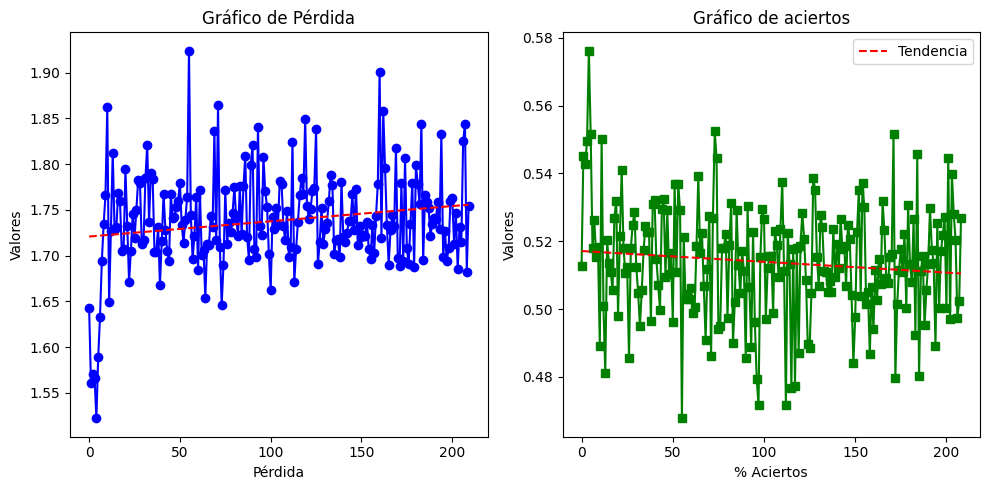

In [ ]:
# Creamos la figura y definimos dos subgráficos (1 fila, 2 columnas)
plt.figure(figsize=(10, 5))

# Primer gráfico en la posición 1 (izquierda)
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
plt.plot(train_loss, color='blue', marker='o')
plt.title("Gráfico de Pérdida")
plt.xlabel("Épocas")
plt.ylabel("Valores de pérdida")

# Calcular la regresión lineal para train_loss
epochs = np.arange(len(train_loss))
m, b = np.polyfit(epochs, train_loss, 1)
plt.plot(epochs, m*epochs + b, color='red', linestyle='--', label='Tendencia')


# Segundo gráfico en la posición 2 (derecha)
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
plt.plot(test_accuracies, color='green', marker='s')
plt.title("Gráfico de aciertos")
plt.xlabel("Épocas")
plt.ylabel("% de aciertos")

# Calcular la regresión lineal para test_accuracies
epochs_test = np.arange(len(test_accuracies))
m, b = np.polyfit(epochs_test, test_accuracies, 1)
plt.plot(epochs_test, m*epochs_test + b, color='red', linestyle='--', label='Tendencia')

# Mostramos los gráficos
plt.tight_layout()  # Ajustamos para que no se solapen los gráficos
plt.legend()
plt.show()